In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import classification_report, confusion_matrix

**deep learning libraries**

In [2]:
import tensorflow as tf
import keras
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import applications
from keras.models import Sequential, load_model
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Flatten, Dense, Dropout
from keras.preprocessing import image

import cv2

import warnings
warnings.filterwarnings('ignore')

In [3]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [4]:
directory_train = '/content/drive/MyDrive/deep learning/covid/archive2/Train'
directory_validation ='/content/drive/MyDrive/deep learning/covid/archive2/Val'
directory_test ='/content/drive/MyDrive/deep learning/covid/archive2/Prediction'

**Data agumentation and pre-processing using tensorflow**

In [ ]:
gen = ImageDataGenerator(
    rescale=1./255.,
    horizontal_flip = True,
    vertical_flip = True
)

In [ ]:
train_generator = gen.flow_from_directory(
    directory = directory_train,
    color_mode="rgb",
    target_size = (331,331),
    class_mode="categorical",
    batch_size=8,
    shuffle=True
)

Found 362 images belonging to 2 classes.


In [ ]:
validation_generator = gen.flow_from_directory(
    directory = directory_validation,
    color_mode="rgb",
    target_size = (331,331),
    class_mode="categorical",
    batch_size=8,
    shuffle=True
)

Found 60 images belonging to 2 classes.


In [ ]:
x,y = next(train_generator)
x.shape

(8, 331, 331, 3)

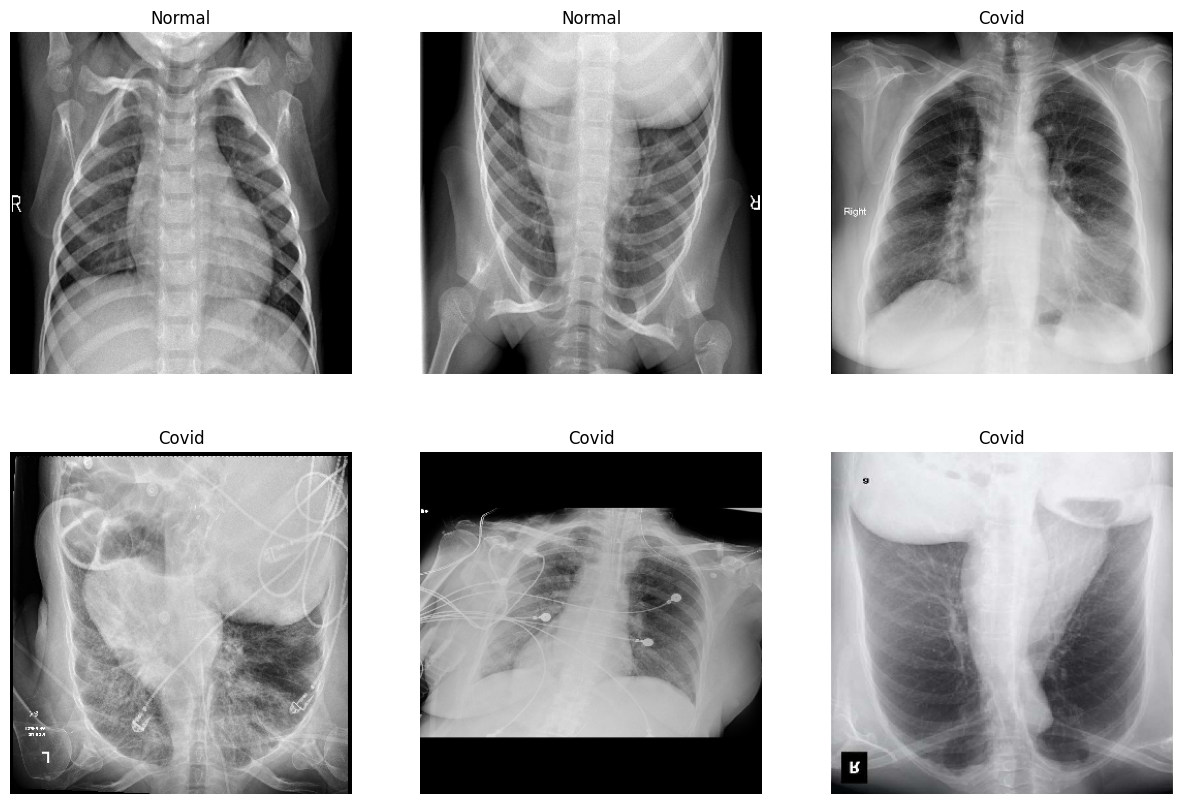

In [ ]:
a = train_generator.class_indices
class_names = list(a.keys())

def plot_images(img,labels):
    plt.figure(figsize=[15,10])
    for i in range(6):
        plt.subplot(2,3,i+1)
        plt.imshow(img[i])
        plt.title(class_names[np.argmax(labels[i])])
        plt.axis('off')

plot_images(x,y)

In [ ]:
base_model = tf.keras.applications.VGG16(
    include_top=False,
    weights='imagenet',
    input_shape=(331,331,3)
)

base_model.trainable=False

model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.BatchNormalization(renorm=True),
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(120, activation='softmax'),
    tf.keras.layers.Dense(2, activation='softmax')
])

58889256/58889256 [==============================] - 0s 0us/step


In [ ]:
model.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['categorical_accuracy'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 10, 10, 512)       14714688  
                                                                 
 batch_normalization (Batch  (None, 10, 10, 512)       3584      
 Normalization)                                                  
                                                                 
 global_average_pooling2d (  (None, 512)               0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 512)               262656    
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 dropout (Dropout)           (None, 256)               0

In [ ]:
early = tf.keras.callbacks.EarlyStopping( patience=10,
                                         min_delta=0.001,
                                         restore_best_weights=True)

In [ ]:
batch_size=8
STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size
STEP_SIZE_VALID = validation_generator.n//validation_generator.batch_size

# fit model
history = model.fit(train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=validation_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=25,
                    callbacks=[early]
)

Epoch 1/25
45/45 [==============================] - 116s 2s/step - loss: 0.6655 - categorical_accuracy: 0.5972 - val_loss: 0.6280 - val_categorical_accuracy: 0.5000
Epoch 2/25
45/45 [==============================] - 13s 286ms/step - loss: 0.5473 - categorical_accuracy: 0.8814 - val_loss: 0.5040 - val_categorical_accuracy: 0.9286
Epoch 3/25
45/45 [==============================] - 12s 262ms/step - loss: 0.4872 - categorical_accuracy: 0.9237 - val_loss: 0.4578 - val_categorical_accuracy: 0.9821
Epoch 4/25
45/45 [==============================] - 12s 261ms/step - loss: 0.4457 - categorical_accuracy: 0.9463 - val_loss: 0.4337 - val_categorical_accuracy: 0.9643
Epoch 5/25
45/45 [==============================] - 19s 429ms/step - loss: 0.4054 - categorical_accuracy: 0.9661 - val_loss: 0.4027 - val_categorical_accuracy: 0.9643
Epoch 6/25
45/45 [==============================] - 12s 267ms/step - loss: 0.3859 - categorical_accuracy: 0.9605 - val_loss: 0.3821 - val_categorical_accuracy: 0.9643


In [ ]:
acc = history.history['categorical_accuracy']
val_acc1 = history.history['val_categorical_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

Text(0.5, 1.0, '\nTraining and Validation Accuracy. \nTrain Accuracy: 0.9774011373519897 \nValidation Accuracy: 0.9464285969734192')

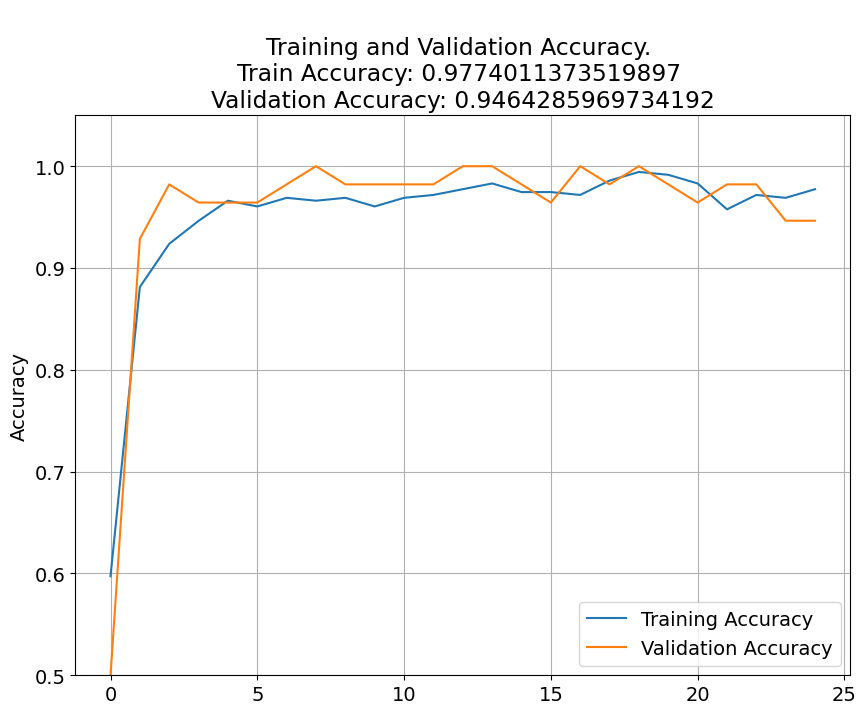

In [ ]:
plt.figure(figsize=(10, 16))
plt.rcParams['figure.figsize'] = [16, 9]
plt.rcParams['font.size'] = 14
plt.rcParams['axes.grid'] = True
plt.rcParams['figure.facecolor'] = 'white'
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc1, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([0.5,1.05])
plt.title(f'\nTraining and Validation Accuracy. \nTrain Accuracy: {(str(acc[-1]))} \nValidation Accuracy: {str(val_acc1[-1])}')

In [ ]:
base_model1 = tf.keras.applications.MobileNetV2(
    include_top=False,
    weights='imagenet',
    input_shape=(224, 224, 3)  # Adjust input shape if needed
)

base_model1.trainable = False

model = tf.keras.Sequential([
    base_model1,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(120, activation='softmax'),  # Assuming you have 120 classes
    tf.keras.layers.Dense(2, activation='softmax')
])

9406464/9406464 [==============================] - 0s 0us/step


In [ ]:
model.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['categorical_accuracy'])


In [ ]:
model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d_1  (None, 1280)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_5 (Dense)             (None, 512)               655872    
                                                                 
 dense_6 (Dense)             (None, 256)               131328    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_7 (Dense)             (None, 128)              

In [ ]:
import matplotlib.pyplot as plt

batch_size = 8
epochs = 25


STEP_SIZE_TRAIN = train_generator.n // train_generator.batch_size
STEP_SIZE_VALID = validation_generator.n // validation_generator.batch_size

early_stopping = tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)


In [ ]:
history = model.fit(train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=validation_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=epochs,
                    callbacks=[early_stopping])

Epoch 1/25
45/45 [==============================] - 16s 256ms/step - loss: 0.5974 - categorical_accuracy: 0.8164 - val_loss: 0.5149 - val_categorical_accuracy: 0.9821
Epoch 2/25
45/45 [==============================] - 10s 233ms/step - loss: 0.5121 - categorical_accuracy: 0.9463 - val_loss: 0.4747 - val_categorical_accuracy: 1.0000
Epoch 3/25
45/45 [==============================] - 10s 231ms/step - loss: 0.4890 - categorical_accuracy: 0.9350 - val_loss: 0.4820 - val_categorical_accuracy: 0.9286
Epoch 4/25
45/45 [==============================] - 12s 265ms/step - loss: 0.4470 - categorical_accuracy: 0.9633 - val_loss: 0.4180 - val_categorical_accuracy: 1.0000
Epoch 5/25
45/45 [==============================] - 11s 251ms/step - loss: 0.4105 - categorical_accuracy: 0.9774 - val_loss: 0.4134 - val_categorical_accuracy: 0.9643
Epoch 6/25
45/45 [==============================] - 11s 248ms/step - loss: 0.3900 - categorical_accuracy: 0.9746 - val_loss: 0.4313 - val_categorical_accuracy: 0.928

In [ ]:
acc = history.history['categorical_accuracy']
val_acc2 = history.history['val_categorical_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

Text(0.5, 1.0, '\nTraining and Validation Accuracy. \nTrain Accuracy: 0.9944 \nValidation Accuracy: 1.0000')

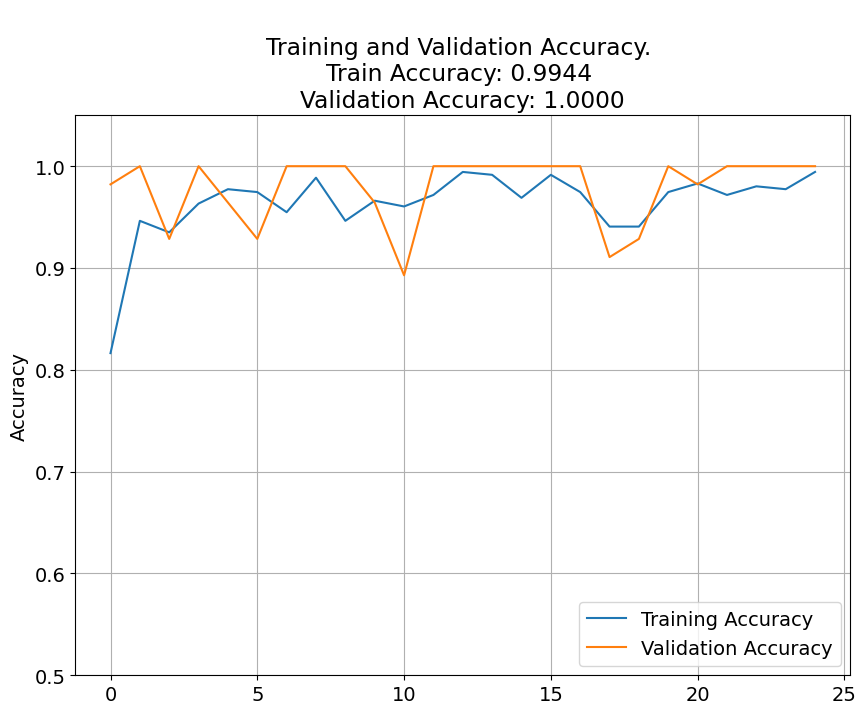

In [ ]:
plt.figure(figsize=(10, 16))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc2, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1.05])
plt.title(f'\nTraining and Validation Accuracy. \nTrain Accuracy: {acc[-1]:.4f} \nValidation Accuracy: {val_acc2[-1]:.4f}')

In [ ]:
base_model2 = tf.keras.applications.InceptionV3(
    include_top=False,
    weights='imagenet',
    input_shape=(224, 224, 3)  # Adjust input shape if needed
)

base_model2.trainable = False

model = tf.keras.Sequential([
    base_model2,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(120, activation='softmax'),  # Assuming you have 120 classes
    tf.keras.layers.Dense(2, activation='softmax')
])

87910968/87910968 [==============================] - 0s 0us/step


In [ ]:
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 global_average_pooling2d_2  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_10 (Dense)            (None, 512)               1049088   
                                                                 
 dense_11 (Dense)            (None, 256)               131328    
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                                 
 dense_12 (Dense)            (None, 128)               32896     
                                                      

In [ ]:
import matplotlib.pyplot as plt

batch_size = 8
epochs = 25

STEP_SIZE_TRAIN = train_generator.n // train_generator.batch_size
STEP_SIZE_VALID = validation_generator.n // validation_generator.batch_size

early_stopping = tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)

In [ ]:
history = model.fit(train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=validation_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=epochs,
                    callbacks=[early_stopping])

Epoch 1/25
45/45 [==============================] - 21s 320ms/step - loss: 0.6783 - categorical_accuracy: 0.5960 - val_loss: 0.7011 - val_categorical_accuracy: 0.5000
Epoch 2/25
45/45 [==============================] - 11s 235ms/step - loss: 0.6435 - categorical_accuracy: 0.6525 - val_loss: 0.5589 - val_categorical_accuracy: 0.8750
Epoch 3/25
45/45 [==============================] - 11s 243ms/step - loss: 0.5666 - categorical_accuracy: 0.8192 - val_loss: 0.4752 - val_categorical_accuracy: 1.0000
Epoch 4/25
45/45 [==============================] - 12s 263ms/step - loss: 0.4735 - categorical_accuracy: 0.9463 - val_loss: 0.4427 - val_categorical_accuracy: 0.9821
Epoch 5/25
45/45 [==============================] - 10s 228ms/step - loss: 0.4459 - categorical_accuracy: 0.9379 - val_loss: 0.4102 - val_categorical_accuracy: 0.9821
Epoch 6/25
45/45 [==============================] - 11s 237ms/step - loss: 0.4244 - categorical_accuracy: 0.9407 - val_loss: 0.3759 - val_categorical_accuracy: 1.000

In [ ]:
acc = history.history['categorical_accuracy']
val_acc3 = history.history['val_categorical_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

Text(0.5, 1.0, '\nTraining and Validation Accuracy. \nTrain Accuracy: 0.9492 \nValidation Accuracy: 0.9821')

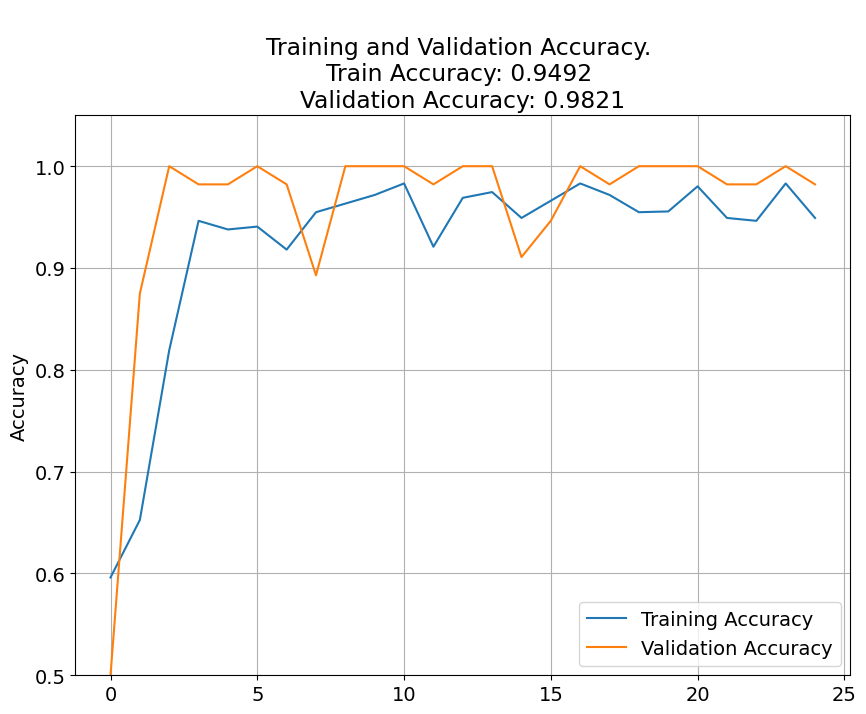

In [ ]:
plt.figure(figsize=(10, 16))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc3, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1.05])
plt.title(f'\nTraining and Validation Accuracy. \nTrain Accuracy: {acc[-1]:.4f} \nValidation Accuracy: {val_acc3[-1]:.4f}')

In [ ]:
base_model3 = tf.keras.applications.ResNet50(
    include_top=False,
    weights='imagenet',
    input_shape=(224, 224, 3)
)

base_model3.trainable = False

model = tf.keras.Sequential([
    base_model3,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(120, activation='softmax'),  # Assuming you have 120 classes
    tf.keras.layers.Dense(2, activation='softmax')
])

94765736/94765736 [==============================] - 0s 0us/step


In [ ]:
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [ ]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d_3  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_15 (Dense)            (None, 512)               1049088   
                                                                 
 dense_16 (Dense)            (None, 256)               131328    
                                                                 
 dropout_3 (Dropout)         (None, 256)               0         
                                                                 
 dense_17 (Dense)            (None, 128)               32896     
                                                      

In [ ]:
batch_size = 8
epochs = 25

STEP_SIZE_TRAIN = train_generator.n // train_generator.batch_size
STEP_SIZE_VALID = validation_generator.n // validation_generator.batch_size

early_stopping = tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)


In [ ]:
history = model.fit(train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=validation_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=epochs,
                    callbacks=[early_stopping])

Epoch 1/25
45/45 [==============================] - 18s 283ms/step - loss: 0.6808 - categorical_accuracy: 0.5960 - val_loss: 0.7050 - val_categorical_accuracy: 0.4821
Epoch 2/25
45/45 [==============================] - 12s 259ms/step - loss: 0.6741 - categorical_accuracy: 0.6045 - val_loss: 0.6982 - val_categorical_accuracy: 0.5179
Epoch 3/25
45/45 [==============================] - 13s 280ms/step - loss: 0.6749 - categorical_accuracy: 0.5989 - val_loss: 0.7052 - val_categorical_accuracy: 0.5000
Epoch 4/25
45/45 [==============================] - 11s 240ms/step - loss: 0.6732 - categorical_accuracy: 0.6017 - val_loss: 0.7070 - val_categorical_accuracy: 0.5000
Epoch 5/25
45/45 [==============================] - 10s 211ms/step - loss: 0.6722 - categorical_accuracy: 0.6045 - val_loss: 0.7171 - val_categorical_accuracy: 0.4821
Epoch 6/25
45/45 [==============================] - 12s 256ms/step - loss: 0.6727 - categorical_accuracy: 0.6017 - val_loss: 0.6970 - val_categorical_accuracy: 0.535

In [ ]:
acc = history.history['categorical_accuracy']
val_acc4 = history.history['val_categorical_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

Text(0.5, 1.0, '\nTraining and Validation Accuracy. \nTrain Accuracy: 0.5989 \nValidation Accuracy: 0.5179')

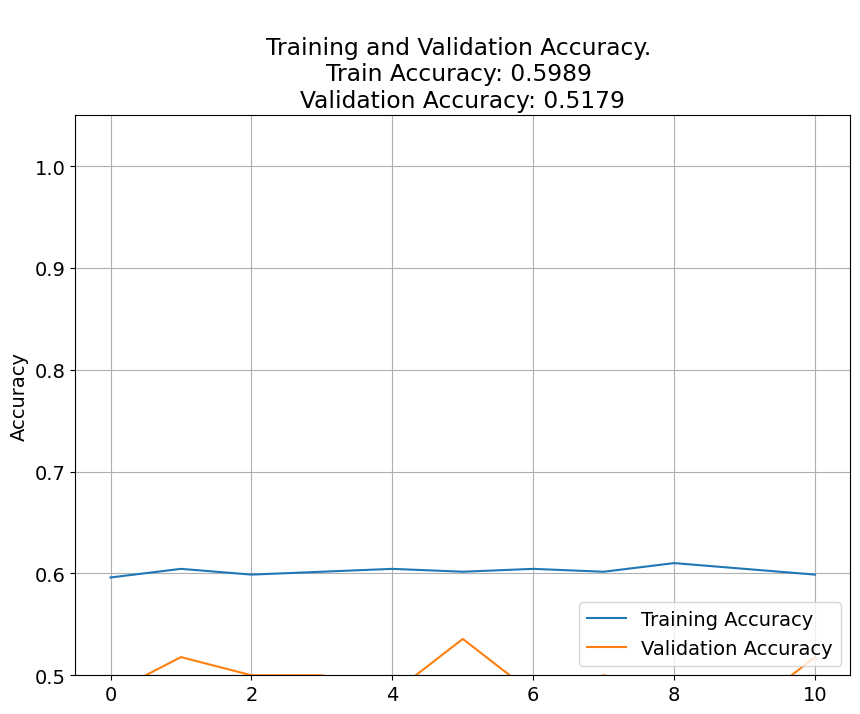

In [ ]:
plt.figure(figsize=(10, 16))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc4, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1.05])
plt.title(f'\nTraining and Validation Accuracy. \nTrain Accuracy: {acc[-1]:.4f} \nValidation Accuracy: {val_acc4[-1]:.4f}')

Text(0.5, 1.0, 'SCORE')

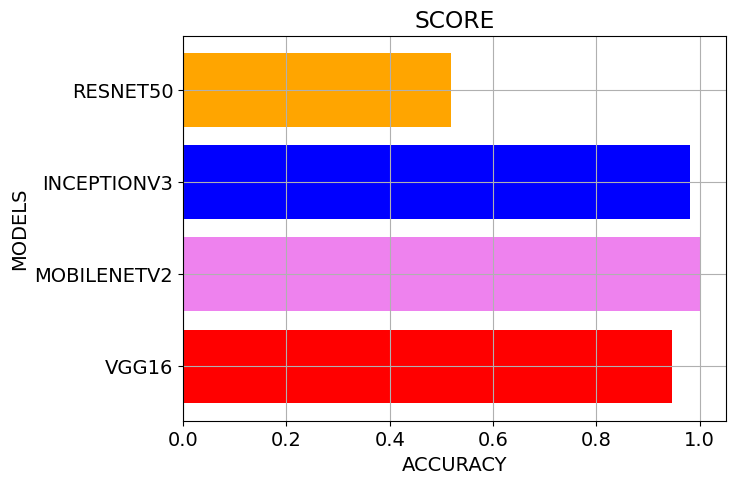

In [ ]:
import matplotlib.pyplot as plt
models=['VGG16','MOBILENETV2','INCEPTIONV3','RESNET50']
accuracy=[val_acc1[-1],val_acc2[-1],val_acc3[-1],val_acc4[-1]]

plt.figure(figsize=(7,5))
c = ['red', 'violet', 'blue','orange']
plt.barh(models,accuracy,align='center',color=c)

plt.xlabel("ACCURACY")
plt.ylabel("MODELS")
plt.title("SCORE")